<a href="https://colab.research.google.com/github/faizankshaikh/AmongUs_StatsChecker/blob/main/GetYourStats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Install required libraries

In [1]:
! pip install -q easyocr

     |████████████████████████████████| 48.9MB 59kB/s 


In [2]:
! pip install -q pyngrok

In [3]:
! pip install -q streamlit

     |████████████████████████████████| 7.4MB 5.4MB/s 
     |████████████████████████████████| 133kB 54.0MB/s 
     |████████████████████████████████| 102kB 14.9MB/s 
     |████████████████████████████████| 112kB 56.8MB/s 
     |████████████████████████████████| 163kB 53.1MB/s 
     |████████████████████████████████| 4.5MB 58.8MB/s 
     |████████████████████████████████| 6.7MB 53.2MB/s 
     |████████████████████████████████| 71kB 11.4MB/s 
     |████████████████████████████████| 71kB 10.8MB/s 
     |████████████████████████████████| 122kB 50.0MB/s 
ERROR: google-colab 1.0.0 has requirement ipykernel~=4.10, but you'll have ipykernel 5.3.4 which is incompatible.
ERROR: botocore 1.19.6 has requirement urllib3<1.26,>=1.25.4; python_version != "3.4", but you'll have urllib3 1.24.3 which is incompatible.


* **Note: Remember to restart the runtime before running the cells below. Also, make sure to use GPU runtime**

## 2. Setting up the system

In [1]:
! git clone https://github.com/faizankshaikh/AmongUs_StatsChecker.git

Cloning into 'AmongUs_StatsChecker'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 25 (delta 8), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (25/25), done.


In [2]:
!mkdir processed_images

In [3]:
data_dir = "AmongUs_StatsChecker"

## 3. Parsing a sample image

In [4]:
# import important libraries
%matplotlib inline

import os
import cv2
import easyocr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob
from scipy.stats import norm, percentileofscore

In [5]:
reader = easyocr.Reader(['en']) 

**Note: If you want to try your own image, upload it on colab and change the path below**

In [6]:
user_name = "bot_ff"
img_path = os.path.join(data_dir, 'bot_ff.jpeg')

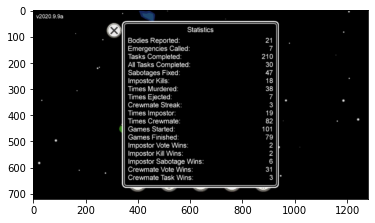

In [7]:
img = cv2.imread(img_path)
plt.imshow(img)

In [8]:
#@title // Preprocess the image
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

thresh_inv = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)[1]

# Blur the image
blur = cv2.GaussianBlur(thresh_inv, (1, 1), 0)

thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

# find contours
contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

mask = np.ones(img.shape[:2], dtype="uint8") * 255
for c in contours:
    # get the bounding rect
    x, y, w, h = cv2.boundingRect(c)
    if w * h > 0.2 * img.shape[0] * img.shape[1]:
        cv2.rectangle(mask, (x, y), (x + w, y + h), (0, 0, 255), -1)

res_final = cv2.bitwise_and(img, img, mask=cv2.bitwise_not(mask))
mask_out = cv2.subtract(cv2.bitwise_not(mask), thresh_inv)

def get_segment_crop(img, tol=0, mask=None):
    if mask is None:
        mask = img > tol
    return img[np.ix_(mask.any(1), mask.any(0))]

result = get_segment_crop(img, mask=cv2.bitwise_not(mask))

width = 600
height = 650
dim = (width, height)

# resize image
result = cv2.resize(result, dim, interpolation=cv2.INTER_AREA)

result = result[30:-30, int(0.666 * result.shape[1]) :]

# cv2_imshow(result)
cv2.imwrite("processed_images/" + user_name + ".jpeg", result);

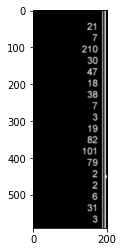

In [9]:
plt.imshow(plt.imread("processed_images/" + user_name + ".jpeg"))

In [10]:
# parse preprocessed image
result = reader.readtext(
    "processed_images/" + user_name + ".jpeg",
    decoder="greedy",
    detail=0,
    mag_ratio=2.5,
    text_threshold=0.6,
    low_text=0.339
)

In [11]:
stats = [img_path.rsplit('/')[-1].split(".")[0]]
for r in result:
    if r.isnumeric():
        stats.append(int(r))

stats, len(stats)

(['bot_ff', 21, 7, 210, 30, 47, 18, 38, 7, 3, 19, 82, 101, 79, 2, 2, 6, 31, 3],
 19)

In [12]:
# check if all data is parsed
assert len(stats) == 19

In [13]:
df = pd.read_csv(os.path.join(data_dir, 'info.csv'))

In [14]:
stats = stats + list(np.zeros(6, dtype='int'))
df = df.append(pd.Series(stats, df.columns), ignore_index=True)

In [15]:
df.head()

,Player Name,Bodies Reported,Emergencies Called,Tasks Completed,All Tasks Completed,Sabotages Fixed,Impostor Kills,Times Murdered,Times Ejected,Crewmate Streak,Times Impostor,Times Crewmate,Games Started,Games Finished,Impostor Vote Wins,Impostor Kill Wins,Impostor Sabotage Wins,Crewmate Vote Wins,Crewmate Task Wins,Tasks Completion Rate,Game completion rate,Impostor win rate,Crewmate win rate,Total win rate,Ejection Rate
0,jd,58,16,364,37,116,71,49,41,0,44,177,221,200,11,16,1,116,1,16.742081,90.497738,63.636364,66.101695,65.610860,18.552036
1,sagar,35,43,418,47,154,55,59,35,0,31,195,226,210,6,10,1,122,3,20.796460,92.920354,54.838710,64.102564,62.831858,15.486726
2,ashok,1,1,61,7,9,13,11,11,4,12,25,37,36,2,0,1,18,0,18.918919,97.297297,25.000000,72.000000,56.756757,29.729730
3,sannata,22,8,249,21,67,36,45,33,7,28,156,184,172,4,4,0,96,0,11.413043,93.478261,28.571429,61.538462,56.521739,17.934783
4,vt,9,6,139,13,38,35,25,20,12,31,103,134,120,6,4,1,61,3,9.701493,89.552239,35.483871,62.135922,55.970149,14.925373


In [16]:
#@title // Calculate Overall Stats
df["Tasks Completion Rate"] = df["All Tasks Completed"] * 100 / df["Games Started"]
df["Game completion rate"] = df["Games Finished"] * 100 / df["Games Started"]
df["Impostor win rate"] = (df["Impostor Vote Wins"] + df["Impostor Kill Wins"] + df["Impostor Sabotage Wins"]) * 100 / df["Times Impostor"]
df["Crewmate win rate"] = (df["Crewmate Vote Wins"] + df["Crewmate Task Wins"]) * 100 / df["Times Crewmate"]
df["Total win rate"] = (df["Crewmate Vote Wins"] + df["Crewmate Task Wins"] + df["Impostor Vote Wins"] + df["Impostor Kill Wins"] + df["Impostor Sabotage Wins"]) * 100 / df["Games Started"]
df["Ejection Rate"] = df["Times Ejected"] * 100 / df["Games Started"]

df.sort_values("Total win rate", ascending=False, inplace=True)
df.reset_index(drop=True, inplace=True)

In [17]:
df[["Player Name", "Total win rate", "Games Started", "Tasks Completion Rate", "Ejection Rate"]]

,Player Name,Total win rate,Games Started,Tasks Completion Rate,Ejection Rate
0,jd,65.610860,221,16.742081,18.552036
1,sagar,62.831858,226,20.796460,15.486726
2,ashok,56.756757,37,18.918919,29.729730
3,sannata,56.521739,184,11.413043,17.934783
4,vt,55.970149,134,9.701493,14.925373
5,seedhe_maut,54.128440,109,31.192661,22.018349
6,gamerzoner,54.022989,87,16.091954,8.045977
7,larry,53.363229,223,19.730942,21.973094
8,don,45.714286,35,14.285714,22.857143
9,situ,45.652174,92,8.695652,17.391304


Info for Player bot_ff

Total win rate: 43.56%
Impostor win rate: 52.63%
Crewmate win rate: 41.46%
All tasks completion rate: 29.70%
---




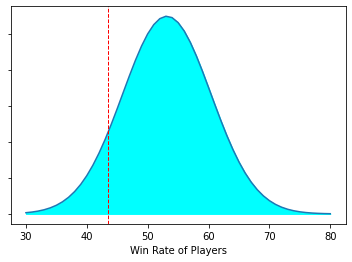

You are better than 12% of the players


In [18]:
#@title // Calculate Personal Stats
row = df.loc[df["Player Name"] == user_name]

print("Info for Player", row["Player Name"].values[0])      
print()
print("Total win rate: {:.2f}%".format(row["Total win rate"].values[0]))
print("Impostor win rate: {:.2f}%".format(row["Impostor win rate"].values[0]))
print("Crewmate win rate: {:.2f}%".format(row["Crewmate win rate"].values[0]))
print("All tasks completion rate: {:.2f}%".format(row["Tasks Completion Rate"].values[0]))
print("---\n\n")

personal_winrate = row["Total win rate"].values[0]

mean, stdev = df[["Total win rate"]].mean().values[0], df[["Total win rate"]].std().values[0]

fig, ax = plt.subplots(1)

x = range(30, 81)
y = norm.pdf(x, mean, stdev)
ax.plot(x, y)
ax.fill_between(x, 0, y, color="cyan")
ax.axvline(personal_winrate, color='red', linestyle='dashed', linewidth=1)
ax.set_yticklabels([])
ax.set_xlabel("Win Rate of Players")

plt.show()

percentile = percentileofscore(df[["Total win rate"]], personal_winrate)
print(f"You are better than {percentile:.0f}% of the players")

## 4. Host a temporary web service

In [19]:
#@title // Create Streamlit app

import os
import cv2
import easyocr
import numpy as np
import pandas as pd
import streamlit as st
import matplotlib.pyplot as plt


from glob import glob
from enum import Enum
from typing import Union
from io import BytesIO, StringIO
from scipy.stats import norm, percentileofscore

st.set_option("deprecation.showfileUploaderEncoding", False)

FILE_TYPES = ["png", "jpeg", "jpg"]
reader = easyocr.Reader(["en"])
PAGE_CONFIG = {"page_title": "StColab.io", "layout": "centered"}
st.beta_set_page_config(**PAGE_CONFIG)
DATA_DIR = "/content/AmongUs_StatsChecker"


class FileType(Enum):
    IMAGE = "Image"


def get_file_type(file: Union[BytesIO, StringIO]) -> FileType:
    if isinstance(file, BytesIO):
        return FileType.IMAGE


def get_segment_crop(img, tol=0, mask=None):
    if mask is None:
        mask = img > tol
    return img[np.ix_(mask.any(1), mask.any(0))]


def preprocess_image(user_name, img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    thresh_inv = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)[1]

    # Blur the image
    blur = cv2.GaussianBlur(thresh_inv, (1, 1), 0)

    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    # find contours
    contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

    mask = np.ones(img.shape[:2], dtype="uint8") * 255
    for c in contours:
        # get the bounding rect
        x, y, w, h = cv2.boundingRect(c)
        if w * h > 0.2 * img.shape[0] * img.shape[1]:
            cv2.rectangle(mask, (x, y), (x + w, y + h), (0, 0, 255), -1)

    res_final = cv2.bitwise_and(img, img, mask=cv2.bitwise_not(mask))
    mask_out = cv2.subtract(cv2.bitwise_not(mask), thresh_inv)

    result = get_segment_crop(img, mask=cv2.bitwise_not(mask))

    width = 600
    height = 650
    dim = (width, height)

    # resize image
    result = cv2.resize(result, dim, interpolation=cv2.INTER_AREA)

    result = result[:-30, int(0.666 * result.shape[1]) :]

    # cv2_imshow(result)
    cv2.imwrite("processed_images/" + user_name + ".jpeg", result)


def get_reply(user_name, img_path):

    preprocess_image(user_name, img_path)

    result = reader.readtext(
        "processed_images/" + user_name + ".jpeg",
        decoder="greedy",
        detail=0,
        text_threshold=0.6,
        low_text=0.339,
        mag_ratio=2.5
    )

    stats = [user_name]
    for r in result:
        if r.isnumeric():
            stats.append(int(r))

    assert len(stats) == 19
    stats = stats + list(np.zeros(6, dtype="int"))
    df = pd.read_csv(os.path.join(DATA_DIR, "info.csv"))
    df = df.append(pd.Series(stats, df.columns), ignore_index=True)

    df["Tasks Completion Rate"] = df["All Tasks Completed"] * 100 / df["Games Started"]
    df["Game completion rate"] = df["Games Finished"] * 100 / df["Games Started"]
    df["Impostor win rate"] = (
        (
            df["Impostor Vote Wins"]
            + df["Impostor Kill Wins"]
            + df["Impostor Sabotage Wins"]
        )
        * 100
        / df["Times Impostor"]
    )
    df["Crewmate win rate"] = (
        (df["Crewmate Vote Wins"] + df["Crewmate Task Wins"])
        * 100
        / df["Times Crewmate"]
    )
    df["Total win rate"] = (
        (
            df["Crewmate Vote Wins"]
            + df["Crewmate Task Wins"]
            + df["Impostor Vote Wins"]
            + df["Impostor Kill Wins"]
            + df["Impostor Sabotage Wins"]
        )
        * 100
        / df["Games Started"]
    )
    df["Ejection Rate"] = df["Times Ejected"] * 100 / df["Games Started"]

    df.sort_values("Total win rate", ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)

    row = df.loc[df["Player Name"] == user_name]

    "Info for Player", row["Player Name"].values[0]

    "Total win rate:", round(row["Total win rate"].values[0], 2)

    "Impostor win rate:", round(row["Impostor win rate"].values[0], 2)

    "Crewmate win rate:", round(row["Crewmate win rate"].values[0], 2)

    "All tasks completion rate:", round(row["Tasks Completion Rate"].values[0], 2)

    st.text("---\n\n")

    personal_winrate = row["Total win rate"].values[0]

    mean, stdev = (
        df[["Total win rate"]].mean().values[0],
        df[["Total win rate"]].std().values[0],
    )

    fig, ax = plt.subplots(1)

    x = range(30, 81)
    y = norm.pdf(x, mean, stdev)
    ax.plot(x, y)
    ax.fill_between(x, 0, y, color="cyan")
    ax.axvline(personal_winrate, color="red", linestyle="dashed", linewidth=1)
    ax.set_yticklabels([])
    ax.set_xlabel("Win Rate of Players")

    st.pyplot(fig, figsize=(10,10))

    percentile = percentileofscore(df[["Total win rate"]], personal_winrate)

    "You are better than", round(percentile), "% of the players"


def main():
    st.title("Among Us Stats Checker")
    menu = ["Home", "Leaderboard", "About"]
    choice = st.sidebar.selectbox("Menu", menu)
    if choice == "Home":
        user_name = st.text_input("Username", "")
        file = st.file_uploader("Upload file", type=FILE_TYPES)
        show_file = st.empty()
        if not file:
            show_file.info("Please upload a file of type: " + ", ".join(FILE_TYPES))
            return

        file_type = get_file_type(file)

        img_path = user_name + ".jpeg"

        f = open(img_path, "wb")
        f.write(file.getvalue())

        file.close()
        f.close()

        get_reply(user_name, img_path)


if __name__ == "__main__":
    main()

In [20]:
!streamlit run app.py &>/dev/null&

In [21]:
#@title // Deploy the web service
from pyngrok import ngrok

public_url = ngrok.connect(port='8501');

2020-10-28 11:30:11.914 INFO    pyngrok.ngrok: Opening tunnel named: http-80-e17fcbd9-d7ba-4fd8-9e07-cbd63315e1bd


2020-10-28 11:30:13.325 INFO    pyngrok.process.ngrok: t=2020-10-28T11:30:13+0000 lvl=info msg="no configuration paths supplied"
2020-10-28 11:30:13.328 INFO    pyngrok.process.ngrok: t=2020-10-28T11:30:13+0000 lvl=info msg="using configuration at default config path" path=/root/.ngrok2/ngrok.yml
2020-10-28 11:30:13.329 INFO    pyngrok.process.ngrok: t=2020-10-28T11:30:13+0000 lvl=info msg="open config file" path=/root/.ngrok2/ngrok.yml err=nil
2020-10-28 11:30:13.336 INFO    pyngrok.process.ngrok: t=2020-10-28T11:30:13+0000 lvl=info msg="starting web service" obj=web addr=127.0.0.1:4040
2020-10-28 11:30:13.640 INFO    pyngrok.process.ngrok: t=2020-10-28T11:30:13+0000 lvl=info msg="tunnel session started" obj=tunnels.session
2020-10-28 11:30:13.641 INFO    pyngrok.process.ngrok: t=2020-10-28T11:30:13+0000 lvl=info msg="client session established" obj=csess id=67d671aeffdc
2020-10-28 11:30:13.648 INFO    pyngrok.process.ngrok: t=2020-10-28T11:30:13+0000 lvl=info msg=start pg=/api/tunnel

In [22]:
public_url

<NgrokTunnel: "http://1a16d74349e2.ngrok.io" -> "http://localhost:80">

**Note: Open the hosted web service using above link**